<a href="https://colab.research.google.com/github/costacis21/Brain-Tumor-Radiogenomic-Classification/blob/main/2d_testing_wtest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow-io==0.23.1
%tensorflow_version

!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle
!mkdir ~/.kaggle
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!pip install python3-wget
import wget
!pip install pydicom

In [5]:
#load data from keggle

!mkdir training

url="https://storage.googleapis.com/kaggle-competitions-data/kaggle-v2/29653/2420395/compressed/train.zip?GoogleAccessId=web-data@kaggle-161607.iam.gserviceaccount.com&Expires=1647612935&Signature=oNAv0GqLVKTd%2BTxvazMiadhu5Ra7J47M6BKcb%2Fdv2WK%2BN2X0GUpyktQwkGpvhBUKrnXiH42lryKsdNtb%2FiVT2%2BWu2hV07BdHYOCdwpKqhH%2FqMDOHzpHqwvJPn8QsibAkUxUiZVgw3V9K0AAM9ZQyFsnxf3QcOtIe2Dwn%2FfZE%2FcXBFcIYo0%2BUHja8OY9%2BnnKa0DPgbx2OEP8JhM97%2B2GriVE6DWNX3KAegZWuOEvZRutbvn5HOdzGf63xw9oxUW2Z4sMOgfv7bXhLPOI%2F9HbBpVORl66kI1LqHzsAhU2cItzixb5WY138kKjWuoOmswXxby0CZ1HvN%2Fo3YEFQ2LUmVw%3D%3D&response-content-disposition=attachment%3B+filename%3Dtrain.zip"
wget.download(url,"training",bar=wget.bar_adaptive)
# !kaggle competitions download -p training/ -c "rsna-miccai-brain-tumor-radiogenomic-classification"

'training/train.zip'

In [3]:
!kaggle -v

Kaggle API 1.5.12


In [6]:
!unzip training/train.zip -d training/

Streaming output truncated to the last 5000 lines.
  inflating: training/00838/T1wCE/Image-124.dcm  
  inflating: training/00838/T1wCE/Image-125.dcm  
  inflating: training/00838/T1wCE/Image-126.dcm  
  inflating: training/00838/T1wCE/Image-127.dcm  
  inflating: training/00838/T1wCE/Image-128.dcm  
  inflating: training/00838/T1wCE/Image-129.dcm  
  inflating: training/00838/T1wCE/Image-13.dcm  
  inflating: training/00838/T1wCE/Image-130.dcm  
  inflating: training/00838/T1wCE/Image-131.dcm  
  inflating: training/00838/T1wCE/Image-132.dcm  
  inflating: training/00838/T1wCE/Image-133.dcm  
  inflating: training/00838/T1wCE/Image-134.dcm  
  inflating: training/00838/T1wCE/Image-135.dcm  
  inflating: training/00838/T1wCE/Image-136.dcm  
  inflating: training/00838/T1wCE/Image-137.dcm  
  inflating: training/00838/T1wCE/Image-138.dcm  
  inflating: training/00838/T1wCE/Image-139.dcm  
  inflating: training/00838/T1wCE/Image-14.dcm  
  inflating: training/00838/T1wCE/Image-140.dcm  
 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_io as tfio
import os
import glob

import pandas as pd
import numpy as np
from pathlib import Path

import random
from tqdm.notebook import tqdm
from tqdm.keras import TqdmCallback



import pydicom # Handle MRI images

import cv2  # OpenCV - https://docs.opencv.org/master/d6/d00/tutorial_py_root.html

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, log_loss

from scipy import ndimage

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers

Text(0.5, 1.0, '0002-T2w-image-100')

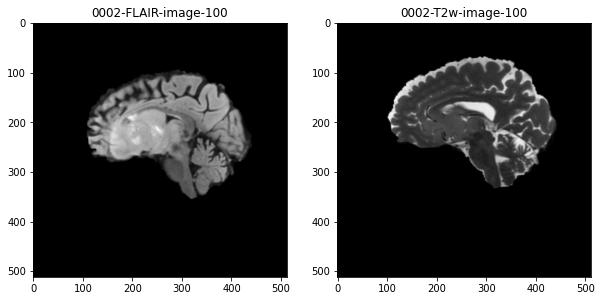

In [3]:
#load two dcm files

image_bytes_1 = tf.io.read_file('training/00002/FLAIR/Image-450.dcm')
image_bytes_2 = tf.io.read_file('training/00002/T2w/Image-200.dcm')

image_1 = tfio.image.decode_dicom_image(image_bytes_1,dtype=tf.uint16)
image_2 = tfio.image.decode_dicom_image(image_bytes_2,dtype=tf.uint16)

fig,axes = plt.subplots(1,2,figsize=(10,10))
axes[0].imshow(np.squeeze(image_1.numpy()),cmap='gray')
axes[0].set_title('0002-FLAIR-image-100')
axes[1].imshow(np.squeeze(image_2.numpy()),cmap='gray')
axes[1].set_title('0002-T2w-image-100')


In [7]:
data_dir = Path('training')

#Read csv file for IDs
mri_types = ["FLAIR", "T1w", "T2w", "T1wCE"]
excluded_images = [109, 123, 709] # Bad images
train_df = pd.read_csv(data_dir / "_labels.csv")

#Remove images with unexpected issues
train_df = train_df[~train_df.BraTS21ID.isin(excluded_images)]

print(f"train data: Rows={train_df.shape[0]}, Columns={train_df.shape[1]}")


train data: Rows=582, Columns=2


In [8]:
def resize_volume(img):
    """Resize across z-axis"""
    # Set the desired depth
    desired_depth = 64
    desired_width = 128
    desired_height = 128
    # Get current depth
    current_depth = img.shape[-1]
    current_width = img.shape[0]
    current_height = img.shape[1]
    # Compute depth factor
    depth = current_depth / desired_depth
    width = current_width / desired_width
    height = current_height / desired_height
    depth_factor = 1 / depth
    width_factor = 1 / width
    height_factor = 1 / height
    # Resize across z-axis
    img = ndimage.zoom(img, (width_factor, height_factor, depth_factor), order=3)
    return img

def load_dicom(path, d_size= (128,128,64)):
    dicom = pydicom.read_file(path)
    data = dicom.pixel_array
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return cv2.resize(data, dsize=d_size[:2])

def load_dicom2(path):
    data = np.concatenate([tf.expand_dims(pydicom.read_file(p).pixel_array, axis=-1) for p in path], axis=2)
    if np.max(data) != 0:
        data = data / np.max(data)
    data = (data * 255).astype(np.uint8)
    return resize_volume(data)



In [9]:
def get_all_image_paths(brats21id, image_type, folder=''):
    assert(image_type in mri_types)
    
    patient_path = os.path.join(folder,
                str(brats21id).zfill(5)
    )
    
    paths = sorted(
        glob.glob(os.path.join(patient_path, image_type, "*"))
    )

    num_images = len(paths)
    start = int(num_images * 0.25)
    end = int(num_images * 0.75)

    interval = 1
    
    return np.array(paths[start:end:interval])

def get_all_images(brats21id, image_type, folder=''):
    return [load_dicom(path) for path in get_all_image_paths(brats21id, image_type, folder)]

def get_all_images2(brats21id, image_type, folder=''):
    return [load_dicom2(get_all_image_paths(brats21id, image_type, folder))]

def get_all_data_for_train(mri_type):
    global train_df
    
    X = []
    y = []
    train_ids = []
    images=[]

    for i in tqdm(train_df.index):
        x = train_df.loc[i]
        
        images = get_all_images(brats21id=int(x['BraTS21ID']), image_type=mri_type, folder='training/')
        
        label = x['MGMT_value']

        X += images
        y += [label] * len(images)
        train_ids += [int(x['BraTS21ID'])] * len(images)
        assert(len(X) == len(y))
    return np.array(X), np.array(y), np.array(train_ids)

In [10]:

from skimage import morphology
##Pre processing


def remove_noise(image, display=False):
    
    
    brain_image = image
    
    segmentation = morphology.dilation(brain_image, np.ones((1, 1)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    label_count[0] = 0

    mask = labels == label_count.argmax()
 
    mask = morphology.dilation(mask, np.ones((1, 1)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    masked_image = mask * brain_image
    return masked_image

def crop_image(image,display=None):
  mask=image=1

  coords= np.array(np.nonzero(~mask))
  top_left=np.min(coords,axis=1)
  bottom_right = np.max(coords,axis=1)

  croped_image=image[top_left[0]:bottom_right[0],top_left[1]:bottom_right[1]]

  return croped_image

In [11]:
X_FLAIR,y_FLAIR,trainidt_FLAIR=get_all_data_for_train("FLAIR")
X_T1W,y_T1W,trainidt_T1W=get_all_data_for_train("T1w")
X_T1WCE,y_T1WCE,trainidt_T1WCE=get_all_data_for_train("T1wCE")
X_T2W,y_T2W,trainidt_T2W=get_all_data_for_train("T2w")





  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

  0%|          | 0/582 [00:00<?, ?it/s]

In [12]:

def load_mri_type(mri_type):
  global X, y, trainidt 

  if mri_type =="FLAIR":   
    X,y,trainidt = X_FLAIR,y_FLAIR,trainidt_FLAIR
  if mri_type =="T1w":   
    X,y,trainidt = X_T1W,y_T1W,trainidt_T1W
  if mri_type =="T1wCE":   
    X,y,trainidt = X_T1WCE,y_T1WCE,trainidt_T1WCE
  if mri_type =="T2w":   
    X,y,trainidt = X_T2W,y_T2W,trainidt_T2W


(48168, 128, 128)
2
1


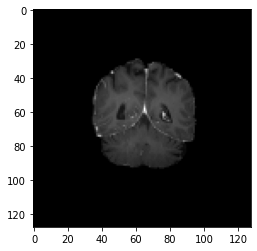

In [9]:
print(X_T1WCE.shape)
print(trainidt_T1WCE[100])
print(y_T1WCE[100])


plt.figure()
plt.imshow(np.squeeze(X_T1WCE[100]),cmap="gray")

In [13]:
def get_3DCNNmodel(width=128, height=128, depth=64, name='3dcnn'):
    """Build a 3D convolutional neural network model."""

    inputs = tf.keras.Input((width, height, depth, 1))

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(inputs)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=64, kernel_size=3, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    # x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.Conv3D(filters=256, kernel_size=5, activation="relu")(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)

    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=512, activation="relu")(x)
    x = tf.keras.layers.Dropout(0.3)(x)

    output = keras.layers.Dense(2, activation="sigmoid")(x)

 
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.0004
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=100000,
        decay_rate=0.96, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')

    model.compile(
        loss="binary_crossentropy", 
        optimizer=keras.optimizers.Adam(),
        metrics=[roc_auc],
    )
    return model

In [32]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr



def get_3DCNNmodel2(width=128, height=128, depth=64, name='3dcnn'):##edited
    """Build a 3D convolutional neural network model."""
    w_init=tf.keras.initializers.HeNormal()

    inputs = tf.keras.Input(shape=(width, height, depth, 1))
  
    x= tf.keras.layers.Conv3D(filters=64,kernel_size=5,)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.MaxPool3D(pool_size=2)(x)

    x= tf.keras.layers.Conv3D(filters=64,kernel_size=5)(inputs)
    x= tf.keras.layers.MaxPool3D(pool_size=2)(x)

    x = tf.keras.layers.Conv3D(filters=128, kernel_size=5 ,activation="relu",padding='same')(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = tf.keras.layers.Conv3D(filters=256, kernel_size=3,activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool3D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Conv3D(filters=512, kernel_size=3, activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool3D(pool_size=4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.2)(x)


  


    x = tf.keras.layers.GlobalAveragePooling3D()(x)
    x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
    # x = tf.keras.layers.Dropout(0.3)(x)

    output = keras.layers.Dense(2, activation="sigmoid")(x)

 
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=82,
        decay_rate=0.80, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')
    optimiser=keras.optimizers.Adam(lr_schedule)
    lr_metric = get_lr_metric(optimiser)
    model.compile(
        loss="binary_crossentropy", 
        optimizer=optimiser,
        metrics=[roc_auc],
    )
    return model

In [14]:
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer._decayed_lr(tf.float32) # I use ._decayed_lr method instead of .lr
    return lr



def get_2DCNNmodel(width=128, height=128, depth=64, name='3dcnn'):##edited
    """Build a 2D convolutional neural network model."""
    w_init=tf.keras.initializers.HeNormal()

    inputs = tf.keras.Input(shape=(width, height, 1))
  
    x= tf.keras.layers.Conv2D(filters=64,kernel_size=5,)(inputs)
    x = tf.keras.layers.Dropout(0.5)(x)
    x= tf.keras.layers.MaxPool2D(pool_size=2)(x)

    x= tf.keras.layers.Conv2D(filters=64,kernel_size=5)(inputs)
    x= tf.keras.layers.MaxPool2D(pool_size=2)(x)

    x = tf.keras.layers.Conv2D(filters=128, kernel_size=5 ,activation="relu",padding='same')(x)
    # x = tf.keras.layers.Dropout(0.3)(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)


    x = tf.keras.layers.Conv2D(filters=256, kernel_size=3,activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=2)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.5)(x)


    x = tf.keras.layers.Conv2D(filters=512, kernel_size=3, activation="relu",padding='same')(x)
    x = tf.keras.layers.MaxPool2D(pool_size=4)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    # x = tf.keras.layers.Dropout(0.2)(x)


  


    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
    x = tf.keras.layers.Dense(units=3072, activation="relu")(x)

    # x = tf.keras.layers.Dropout(0.3)(x)

    output = keras.layers.Dense(2, activation="sigmoid")(x)

 
    model = keras.Model(inputs, output)
    initial_learning_rate =  0.01
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=80,
        decay_rate=0.96, 
        staircase=True
    )
  
    roc_auc = tf.keras.metrics.AUC(name='roc_auc', curve='ROC')
    pr_auc = tf.keras.metrics.AUC(name='pr_auc', curve='PR')

    optimiser=keras.optimizers.Adam(lr_schedule)
    lr_metric = get_lr_metric(optimiser)
    model.compile(
        loss="binary_crossentropy", 
        optimizer=optimiser,
        metrics=[roc_auc,pr_auc],
    )
    return model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 1)]     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 124, 124, 64)      1664      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 62, 62, 128)       204928    
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 31, 31, 128)      0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 31, 31, 128)      512   

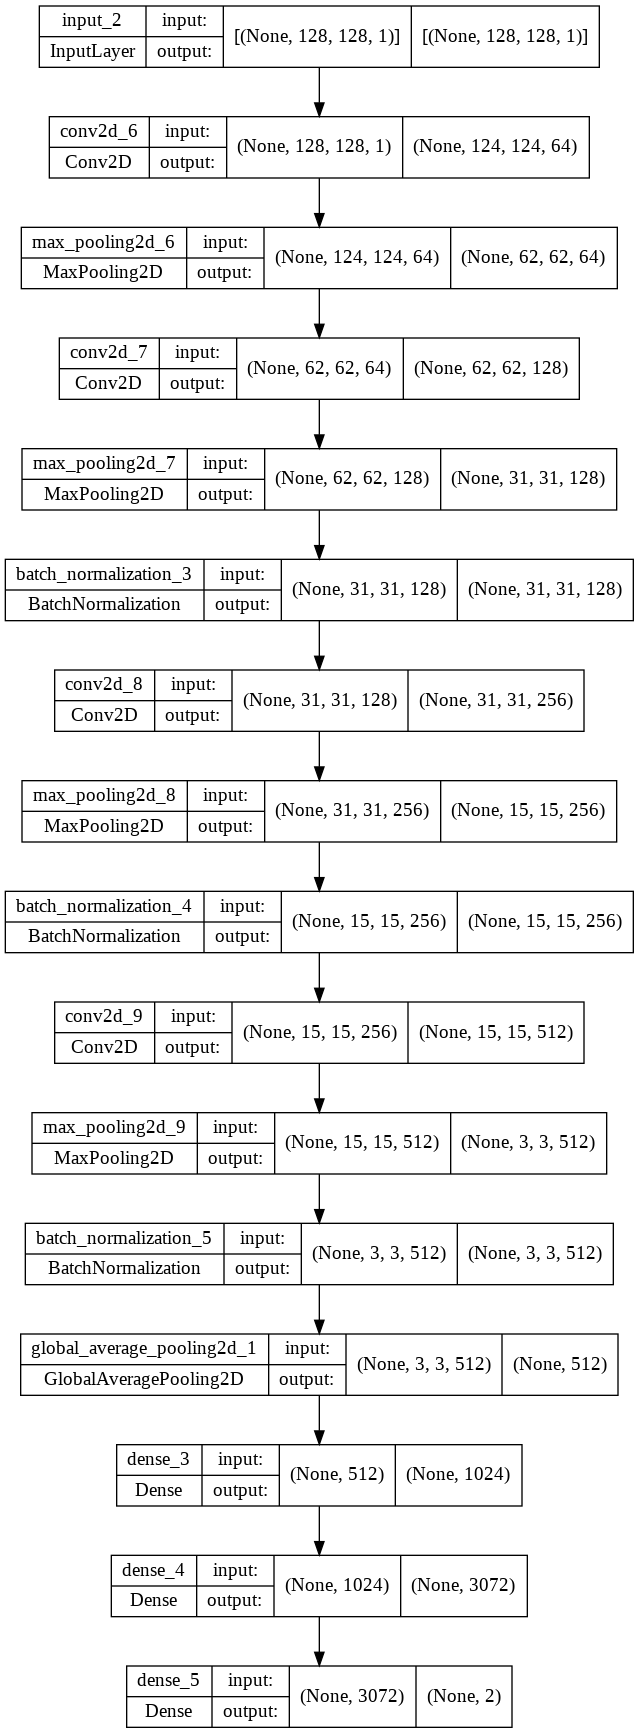

In [9]:
from keras.utils.vis_utils import plot_model
print(get_2DCNNmodel().summary())
plot_model(get_2DCNNmodel() ,to_file='model_plot.png' , show_shapes=True, show_layer_names=True)

In [17]:
""" 
function ConnectButton(){
  console.log("Connect pushed"); 
  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() 
}
setInterval(ConnectButton,60000);
"""

' \nfunction ConnectButton(){\n  console.log("Connect pushed"); \n  document.querySelector("#top-toolbar > colab-connectbutton").shadowRoot.querySelector("#connect").click() \n}\nsetInterval(ConnectButton,60000);\n'

In [16]:
early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_roc_auc", mode='max', patience=20)
###patience=20



In [ ]:
auc_list = []
best_auc = float("-inf")

# round1_mri_type=mri_types[0] #["FLAIR", "T1w", "T2w", "T1wCE"]
# mri_type=mri_types[3]
# model=tf.keras.models.load_model(filepath=f"/content/drive/MyDrive/Colab Notebooks/models/best/2d_best_modelv2.0_T2w.h5")

mri_types=["FLAIR", "T1w", "T2w" , "T1wCE"]
num_of_tries=3
for d,mri_type in enumerate(mri_types[2:]):
    # if(mri_type == round1_mri_type):
    #     print("SKIPPING: "+mri_type)
    #     continue

    print("LOADING: "+mri_type)
    load_mri_type(mri_type)

    
    for i in (range(num_of_tries)):
        
        # commit with test variables
        checkpoint_filepath = f"drive/MyDrive/Colab Notebooks/models/best/2d models/2d_best_modelv3.{i}_T2w_{mri_type}.h5"

        model = get_2DCNNmodel()
        model_checkpoint1_cb = tf.keras.callbacks.ModelCheckpoint(
            filepath=checkpoint_filepath,
            save_weights_only=False,
            mode="max",
            monitor="roc_auc",
            save_best_only=True,
            save_freq=num_of_tries,
            verbose=0,
        )


        X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = \
        train_test_split(X, y, trainidt, test_size=0.3, random_state=i)


        X_train, X_test, y_train, y_test, trainidt_train, trainidt_test = \
        train_test_split(X_train, y_train, trainidt_train, test_size=0.15, random_state=i)


        X_train = tf.expand_dims(X_train, axis=-1)
        X_valid = tf.expand_dims(X_valid, axis=-1)
        X_test = tf.expand_dims(X_test, axis=-1)
        y_train = to_categorical(y_train)
        y_valid = to_categorical(y_valid)
        y_test = to_categorical(y_test)
        

        

        # 582*0.2 = 465 mod 1, 3, 5, 15, 31, 93, 155, 465 =0

        

        history = model.fit(x=X_train,y=y_train, epochs=100, batch_size = 300,\
                            callbacks=[model_checkpoint1_cb, early_stopping_cb],\
                            validation_data=(X_valid, y_valid), verbose=2)
      
        print(model.metrics_names)



        model_best = tf.keras.models.load_model(filepath=checkpoint_filepath)
        y_pred = model_best.predict(X_test,batch_size = 2)

        pred = np.argmax(y_pred, axis=1)

        result = pd.DataFrame(trainidt_test)
        result[1] = pred

        result.columns = ["BraTS21ID", "MGMT_value"]
        result2 = result.groupby("BraTS21ID", as_index=False).mean()

        result2 = result2.merge(train_df, on="BraTS21ID")
        auc = roc_auc_score(
            result2.MGMT_value_y,
            result2.MGMT_value_x,
        )
        print(f"Test AUC={auc}")
        auc_list.append(auc)
        if auc > best_auc:
            best_i = i
            best_auc = auc

        


# TODO input > convolud&maxpool -> dense (decode) >  

LOADING: T2w
Epoch 1/100
99/99 - 85s - loss: 1.5596 - roc_auc: 0.5917 - pr_auc: 0.5628 - val_loss: 1.0033 - val_roc_auc: 0.6166 - val_pr_auc: 0.5964 - 85s/epoch - 860ms/step
Epoch 2/100
99/99 - 44s - loss: 0.6634 - roc_auc: 0.6338 - pr_auc: 0.6233 - val_loss: 1.0398 - val_roc_auc: 0.6099 - val_pr_auc: 0.5895 - 44s/epoch - 443ms/step
Epoch 3/100
99/99 - 45s - loss: 0.6555 - roc_auc: 0.6440 - pr_auc: 0.6402 - val_loss: 0.6858 - val_roc_auc: 0.6185 - val_pr_auc: 0.5954 - 45s/epoch - 451ms/step
Epoch 4/100
99/99 - 45s - loss: 0.6475 - roc_auc: 0.6557 - pr_auc: 0.6559 - val_loss: 0.6995 - val_roc_auc: 0.5921 - val_pr_auc: 0.5726 - 45s/epoch - 454ms/step
Epoch 5/100
99/99 - 44s - loss: 0.6354 - roc_auc: 0.6740 - pr_auc: 0.6763 - val_loss: 0.7733 - val_roc_auc: 0.4654 - val_pr_auc: 0.5029 - 44s/epoch - 441ms/step
Epoch 6/100
99/99 - 44s - loss: 0.6204 - roc_auc: 0.6973 - pr_auc: 0.7006 - val_loss: 0.6915 - val_roc_auc: 0.6098 - val_pr_auc: 0.5899 - 44s/epoch - 449ms/step
Epoch 7/100
99/99 - 4

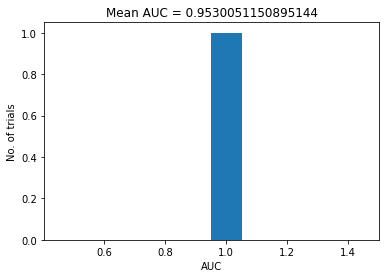

In [36]:
plt.hist(auc_list)
plt.xlabel("AUC")
plt.ylabel("No. of trials")
plt.title(f"Mean AUC = {np.mean(auc_list)}")
plt.show()

In [71]:
for mri_type in mri_types:
  print(f"trained 2d FLAIR on {mri_type}")
  for i in range(5):

    load_mri_type(mri_type)
    X_train, X_valid, y_train, y_valid, trainidt_train, trainidt_valid = \
            train_test_split(X, y, trainidt, test_size=0.3,shuffle=True)

    model_best = tf.keras.models.load_model(filepath="/content/drive/MyDrive/Colab Notebooks/models/best/2d_best_modelv1.0_FLAIR.h5")
    y_pred = model_best.predict(X_valid,verbose=1)

    pred = np.argmax(y_pred, axis=1)

    result = pd.DataFrame(trainidt_valid)
    result[1] = pred

    result.columns = ["BraTS21ID", "MGMT_value"]
    result2 = result.groupby("BraTS21ID", as_index=False).mean()

    result2 = result2.merge(train_df, on="BraTS21ID")
    auc = roc_auc_score(
        result2.MGMT_value_y,
        result2.MGMT_value_x,
    )
    # accuracy = accuracy_score(
    #     result2.MGMT_value_y,
    #     result2.MGMT_value_x,
    # )Validation accuracy={accuracy},
    loss = log_loss(
        result2.MGMT_value_y,
        result2.MGMT_value_x,
    )
    print(f"{i+1}\t Validation AUC={auc},  Validation loss={loss}")


trained 2d FLAIR on FLAIR
347/347 [==============================] - 5s 14ms/step
1	 Validation AUC=0.9926704680446663,  Validation loss=0.3042409227506315
347/347 [==============================] - 4s 12ms/step
2	 Validation AUC=0.9935942976224308,  Validation loss=0.29224355246800227
347/347 [==============================] - 4s 12ms/step
3	 Validation AUC=0.9928817587641118,  Validation loss=0.23701355574680116


KeyboardInterrupt: ignored

In [59]:
auc

0.6247868712702471